- 레스토랑 리뷰 감성 분류하기 :
https://github.com/rickiepark/nlp-with-pytorch/blob/main/chapter_3/3_5_Classifying_Yelp_Review_Sentiment.ipynb

- NLP using GloVe Embeddings(FAKE NEWS) : 
https://www.kaggle.com/code/madz2000/nlp-using-glove-embeddings-99-87-accuracy
- https://www.kaggle.com/code/lorwohl/fake-news-detection

In [47]:
# 모듈 로딩
import numpy as np
import pandas as pd
import re
from string import punctuation

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize, sent_tokenize


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer # used to tokenize text sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences # padding sequences to the same length
from tensorflow.keras.models import Sequential # building sequential models like FF layers in the transformer encoder
from tensorflow.keras.layers import Dense,Embedding # used for parts of the transformer encoder

### [1] 데이터 보기

In [50]:
real = pd.read_csv("./True.csv")
fake = pd.read_csv("./Fake.csv")

In [51]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [52]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [53]:
# real / fake에 범주 부여
real['category']=1
fake['category']=0

In [54]:
# real / fake 합치기
df=pd.concat([real, fake])

0    23481
1    21417
Name: category, dtype: int64
FakeNews : 0.52%
FakeNews : 0.48%


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='category', ylabel='count'>

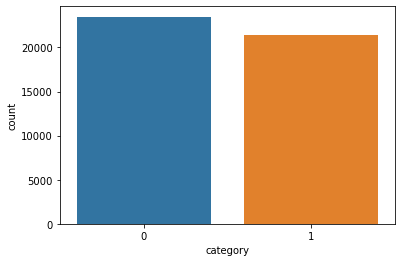

In [7]:
# 카테고리 확인
print(df.category.value_counts())
print(f'FakeNews : {round(df.category.value_counts()[0] / df.category.count(), 2)}%')
print(f'FakeNews : {round(df.category.value_counts()[1] / df.category.count(), 2)}%')

# sns.countplot => 갯수 확인 시각화
sns.countplot(df.category)

In [8]:
# 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44898 non-null  object
 1   text      44898 non-null  object
 2   subject   44898 non-null  object
 3   date      44898 non-null  object
 4   category  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64


<AxesSubplot:xlabel='subject', ylabel='count'>

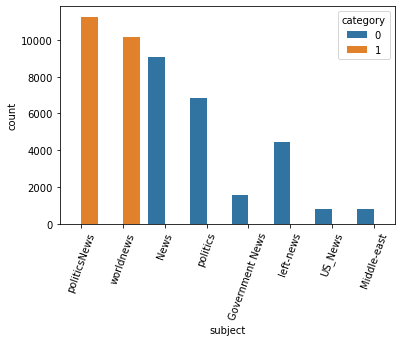

In [9]:
# 뉴스의 종류 확인
print(df.subject.value_counts())

# 카테고리 별 뉴스 종류 확인
plt.xticks(rotation=70)
sns.countplot(x='subject', hue='category', data=df)

In [10]:
# 결측치 확인
df.isnull().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

## [2] 데이터 처리

In [11]:
# 뉴스 기사들을 한 컬럼으로 합치기
df['text_all']=df['text'] + ' ' + df['title']
df['text_all'].head()

0    WASHINGTON (Reuters) - The head of a conservat...
1    WASHINGTON (Reuters) - Transgender people will...
2    WASHINGTON (Reuters) - The special counsel inv...
3    WASHINGTON (Reuters) - Trump campaign adviser ...
4    SEATTLE/WASHINGTON (Reuters) - President Donal...
Name: text_all, dtype: object

### 불용어 처리
string.punctuation -> !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

In [12]:
from wordcloud import WordCloud, STOPWORDS # wordcloud 모듈에도 stopword 기능 있음.
from nltk.corpus import stopwords

stop=set(stopwords.words('english'))
# stopwords=set(nltk.corpus.stopwords.words('english'))
punctuation = string.punctuation
stop.update(punctuation)

### 데이터 분할

In [43]:
# from sklearn.model_selection import train_test_split, 비율에 맞게 분할
X_train, X_test, y_train, y_test = train_test_split(df.text_all, 
                                                    df.category, 
                                                    test_size=0.2, 
                                                    stratify=df.category,
                                                    random_state=11)

print(f'X_train : {X_train.shape}, X_test : {X_test.shape}')

X_train : (35918,), X_test : (8980,)


In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.2, 
                                                  stratify=y_train,
                                                  random_state=11)
print(f'X_train : {X_train.shape}, X_test : {X_test.shape} , X_val : {X_val.shape}')

X_train : (28734,), X_test : (8980,) , X_val : (7184,)


In [42]:
print('\n', '학습 데이터', '-'*20)
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'가짜뉴스 : {round(y_train.value_counts()[0]/len(y_train),2)}%')
print(f'진짜뉴스 : {round(y_train.value_counts()[1]/len(y_train),2)}%')

print('\n', '테스트 데이터', '-'*20)
print(f'X_test   : {X_test.shape}, y_test : {y_test.shape}')
print(f'가짜뉴스 : {round(y_test.value_counts()[0]/len(y_test),2)}%')
print(f'진짜뉴스 : {round(y_test.value_counts()[1]/len(y_test),2)}%')

print('\n', '검증 데이터', '-'*20)
print(f'X_val    : {X_val.shape}, y_val : {y_val.shape}')
print(f'가짜뉴스 : {round(y_val.value_counts()[0]/len(y_val),2)}%')
print(f'진짜뉴스 : {round(y_val.value_counts()[1]/len(y_val),2)}%')


 학습 데이터 --------------------
X_train : (28734,), y_train : (28734,)
가짜뉴스 : 0.52%
진짜뉴스 : 0.48%

 테스트 데이터 --------------------
X_test   : (8980,), y_test : (8980,)
가짜뉴스 : 0.52%
진짜뉴스 : 0.48%

 검증 데이터 --------------------
X_val    : (7184,), y_val : (7184,)
가짜뉴스 : 0.52%
진짜뉴스 : 0.48%


### 데이터 벡터화

In [46]:
# 텍스트 데이터 토큰화 진행 
def makeToken(textData, numWord=0):
    if numWord > 0:
        myToken = Tokenizer(num_words=numWord)
    else:
        myToken=Tokenizer()
    
    # 단어사전(voca) 생성
    myToken.fit_on_texts(textData)
    
    return myToken

In [ ]:
def checkWordCount(tokenizer, freq_num=100):
    